In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

xls = "../data/Electricity_since_1920.xls"
df = pd.read_excel(xls, 'Generated and supplied')

columns_major = ['year', 'e-gen', 'e-work-use', 'total', 'conv-therm', 'ccgt', 'nuclear', 'natural-flow', 'hydro', 'pumped-storage', 'wind', 'e-pump-storage', 'net-electricity-supplied'] 

# Sampling the rows containg the data
df_major = df.iloc[8:109, :13]
df_major.columns = columns_major

df_major = df_major.reset_index(drop=True)

# Processing badly formatted year data
df_major['year'] =  df_major['year'].astype(str)
df_major['year'] = df_major['year'].apply(lambda x: x.replace('(5)',''))

# Converting all null values to nan and then to 0
df_major = df_major.replace('-', np.nan)
df_major = df_major.replace('0', np.nan)
df_major = df_major.fillna(np.nan)

# print(df_major.isnull().sum())
print(f"The dataset contains {df_major.shape[0]} rows and {df_major.shape[1]} columns")

from datetime import datetime
con=df_major['year']
df_major['year']=pd.to_datetime(df_major['year'])
df_major['year_cp'] = df_major['year']
df_major.set_index('year', inplace=True)
df_major.index = pd.DatetimeIndex(df_major.index.values,
                               freq='AS')
#convert to time series:
ts = df_major['total']

df_major.head()


The dataset contains 101 rows and 13 columns


,e-gen,e-work-use,total,conv-therm,ccgt,nuclear,natural-flow,hydro,pumped-storage,wind,e-pump-storage,net-electricity-supplied,year_cp
1920-01-01,4275.0,299.0,3976.0,3964.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,3976.0,1920-01-01
1921-01-01,3890.0,285.0,3605.0,3595.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN,3605.0,1921-01-01
1922-01-01,4541.0,315.0,4226.0,4216.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN,4226.0,1922-01-01
1923-01-01,5289.0,361.0,4928.0,4915.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,4928.0,1923-01-01
1924-01-01,6022.0,395.0,5627.0,5612.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,5627.0,1924-01-01


## Feature Engineering
 Imputing new data in the form of monthly data    

In [ ]:

df_major_fe = df_major
df_major_fe.set_index('year_cp', inplace=True)
df_major_fe.index = pd.DatetimeIndex(df_major_fe.index.values,
                               freq='AS')

df_major_fe = df_major_fe.resample('MS').last().fillna(np.nan)

In [ ]:
df_major_ts = df_major_fe[['total']]
df_major_ts

,total
1920-01-01,3976.00
1920-02-01,NaN
1920-03-01,NaN
1920-04-01,NaN
1920-05-01,NaN
...,...
2019-09-01,NaN
2019-10-01,NaN
2019-11-01,NaN
2019-12-01,NaN


In [ ]:
print(df_major_ts.head(15))
print()
print(df_major_ts.shape)

             total
1920-01-01  3976.0
1920-02-01     NaN
1920-03-01     NaN
1920-04-01     NaN
1920-05-01     NaN
1920-06-01     NaN
1920-07-01     NaN
1920-08-01     NaN
1920-09-01     NaN
1920-10-01     NaN
1920-11-01     NaN
1920-12-01     NaN
1921-01-01  3605.0
1921-02-01     NaN
1921-03-01     NaN

(1201, 1)


<AxesSubplot:>

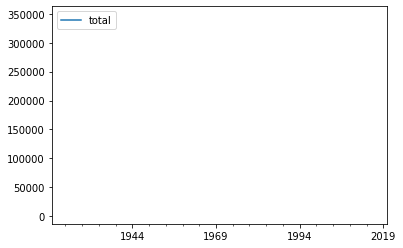

In [ ]:
df_major_ts.plot()

## Interpolating new data

In [ ]:
df_major_impu = df_major_ts.interpolate()

In [ ]:
df_major_impu.count()

total    1201
dtype: int64

<AxesSubplot:>

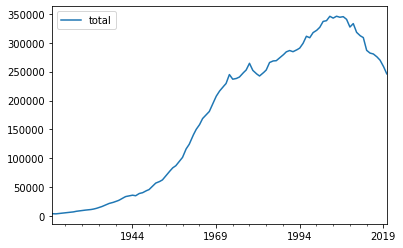

In [ ]:
df_major_impu.plot()

## Forecasting using Prophet

In [ ]:
from prophet import Prophet

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# df_major_final = df_major_impu.reset_index()[['year_cp', 'conv-therm', 'total']].rename({'year_cp':'ds', 'total': 'y', 'conv-therm':'ct'}, axis='columns')

In [ ]:
df_major_impu = df_major_impu.reset_index().rename({'index': 'ds', 'total':'y'}, axis='columns')
df_major_impu

,ds,y
0,1920-01-01,3976.000000
1,1920-02-01,3945.083333
2,1920-03-01,3914.166667
3,1920-04-01,3883.250000
4,1920-05-01,3852.333333
...,...,...
1196,2019-09-01,250600.080000
1197,2019-10-01,249504.790000
1198,2019-11-01,248409.500000
1199,2019-12-01,247314.210000


In [ ]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)
m.fit(df_major_impu)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=10, freq='AS')
future.tail()

,ds
1206,2026-01-01
1207,2027-01-01
1208,2028-01-01
1209,2029-01-01
1210,2030-01-01


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1206,2026-01-01,247164.439933,223807.873764,271700.934567
1207,2027-01-01,243018.601118,208585.945115,274387.218634
1208,2028-01-01,238876.853306,201286.154387,275892.805563
1209,2029-01-01,235267.955513,191307.732567,278651.481509
1210,2030-01-01,231118.161592,183594.295178,282537.341246


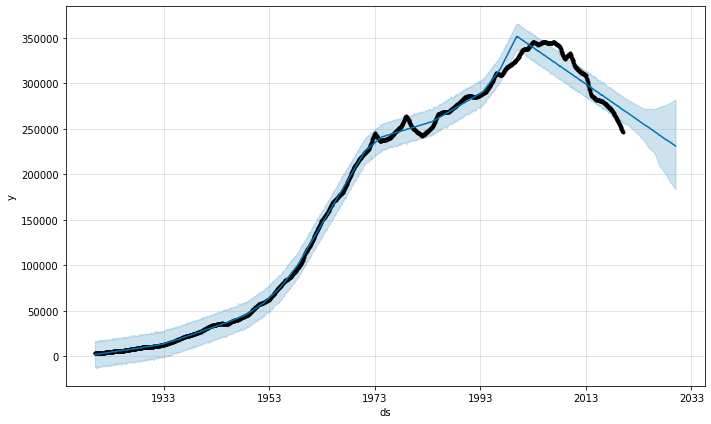

In [ ]:
fig1 = m.plot(forecast)
fig1.savefig('forecast-imputed-data-univariate.png')

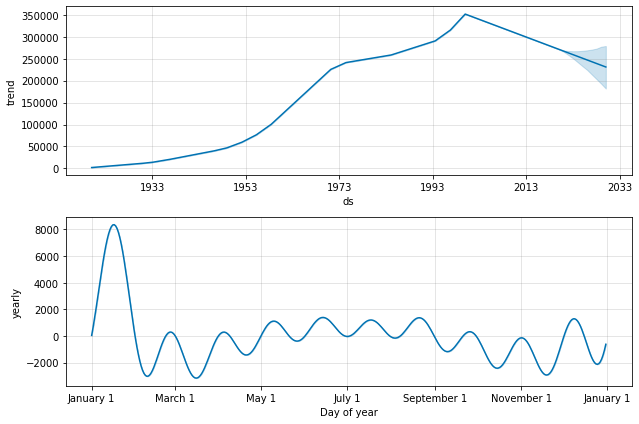

In [ ]:
# The forecast components
fig2 = m.plot_components(forecast)
fig2.savefig('univariate-trend.png')

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4de2e03-9eeb-40d9-be8e-7e4affb2d884' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>